In [3]:
'''
Project: NGuard
Dataset: http://205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/MachineLearningCSV.zip
'''


'\nProject: NGuard\nDataset: http://205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/MachineLearningCSV.zip\n'

**Extracting the parquet file which consist of network flows of Monday,Tuesday,Wednesday,Thursday and Friday**

In [24]:
# from google.colab import drive
# drive.mount('/content/drive')


import pandas as pd
import numpy as np
import glob
import pathlib
import os
from joblib import dump,load


src = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
root_path = os.path.abspath(os.path.join(src, os.pardir))
dataset = f"{root_path}/resources/"


def extract_dataset():
  '''
  Look for the merged parquet file in the cwd,
  if not found unzip the dataset.zip and return the
  cwd of the data.
  '''
  print(dataset)
  file_name = pathlib.Path(f"{dataset}merged.parquet")
  if not file_name.exists ():
    import zipfile
    with zipfile.ZipFile(dataset+"dataset.zip","r") as zip_ref:
      zip_ref.extractall(dataset)
 
  return dataset


def read_as_dataframe(master_file):
  '''
  Look for the merged parquet file in the cwd,
  if not found merge the dataframes and return a single
  merged dataframe.
  '''
  file_name = pathlib.Path(f"{dataset}merged.parquet")
  if not file_name.exists ():
    df = pd.concat(master_file,ignore_index=True)
    df.to_parquet('merged.parquet',index=False)
  else:  
    df = pd.read_parquet(file_name,engine='pyarrow')
  return df


**Extract the data from zip file**

In [25]:
# returns the location of dataset
dirpath = extract_dataset()


/home/shrawan/Desktop/w/Finalyear/NGuard/resources/


**Read parquet file as dataframe**

In [26]:
mon = pd.read_parquet(f'{dirpath}monday.parquet',engine="pyarrow")
tues = pd.read_parquet(f'{dirpath}tuesday.parquet',engine="pyarrow")
wed =  pd.read_parquet(f'{dirpath}wednesday.parquet',engine="pyarrow")
thurs =  pd.concat([
                    pd.read_parquet(f'{dirpath}thursday1.parquet',engine="pyarrow"),
                    pd.read_parquet(f'{dirpath}thursday2.parquet',engine="pyarrow"),
                    ],ignore_index=True)
fri =  pd.concat([pd.read_parquet(f'{dirpath}friday1.parquet',engine="pyarrow"),
                    pd.read_parquet(f'{dirpath}friday2.parquet',engine="pyarrow"),
                    pd.read_parquet(f'{dirpath}friday3.parquet',engine="pyarrow"),
                    ],ignore_index=True)



**Display the total numbers of data in each dataframe**

In [27]:
print('monday', mon[' Label'].unique(),mon[' Label'].count())
print('tuesday', tues[' Label'].unique(),tues[' Label'].count())
print('wednesday', wed[' Label'].unique(),wed[' Label'].count())
print('thursday', thurs[' Label'].unique(),thurs[' Label'].count())
print('friday', fri[' Label'].unique(),fri[' Label'].count())

monday ['BENIGN'] 529918
tuesday ['BENIGN' 'FTP-Patator' 'SSH-Patator'] 445909
wednesday ['BENIGN' 'DoS slowloris' 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye'
 'Heartbleed'] 692703
thursday ['BENIGN' 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection' 'Infiltration'] 458968
friday ['BENIGN' 'Bot' 'PortScan' 'DDoS'] 703245


We can see that monday has only benign data, and other days have mix of attack and benign labels. We can exclude monday data and form a combined dataset of other days.

In [28]:
merged  = read_as_dataframe([tues.drop_duplicates(),wed.drop_duplicates(),thurs.drop_duplicates(),fri.drop_duplicates()])

print(merged[' Label'].value_counts())


BENIGN                        1635861
DoS Hulk                       172849
DDoS                           128016
PortScan                        90819
DoS GoldenEye                   10286
FTP-Patator                      5933
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1953
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name:  Label, dtype: int64


From above we can see, in the total dataset, infiltration, web attack sql injection and heartbleed has comparatively less amount of data



We will ignore them from training data but will use for testing purpose since they would be a type of unseen data for the model

In [29]:
infil = merged.loc[merged[' Label'] == 'Infiltration']
sqli = merged.loc[merged[' Label']== 'Web Attack � Sql Injection']
hb = merged.loc[merged[' Label']== 'Heartbleed']
merged.drop(infil.index,inplace=True)
merged.drop(sqli.index,inplace=True)
merged.drop(hb.index,inplace=True)
new_test = pd.concat([infil,sqli,hb],ignore_index=True)
del infil
del sqli
del hb

**Statistics of merged dataframe**

In [30]:
print(merged.columns)
print(merged.shape)

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

##### The anomaly detection problem can be achieved as either anomaly based approach or even as supervised binary classification approach



---

We will proceed with the later one, converting all attack class lables as single class 'anomaly'.

Using such method we will be left with 2 classes: Binary and Anomaly


In [31]:
labels = merged[' Label'].copy()
print(labels.unique())
labels[labels != 'BENIGN']='ANOMALOUS'
print(labels.unique())

val = labels.value_counts()
print('benign:',(val['BENIGN']/(val['BENIGN']+val['ANOMALOUS']))*100 )
print('anomalous:',(val['ANOMALOUS']/(val['BENIGN']+val['ANOMALOUS'])*100 ))

['BENIGN' 'FTP-Patator' 'SSH-Patator' 'DoS slowloris' 'DoS Slowhttptest'
 'DoS Hulk' 'DoS GoldenEye' 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Bot' 'PortScan' 'DDoS']
['BENIGN' 'ANOMALOUS']
benign: 79.34636515719531
anomalous: 20.653634842804696


From above we see the dataset is pretty unbalanced for supervised learning.
Such imbalance can cause overfitting to a perticular class especially benign.

**Data post processing**

Before splitting the dataset into train and test, there are some considirations to be taken.


---
Frome the dataset these would be dropped:
***Destination port***; reason no significance since services are run on any port by the host, example: ssh service can be run for any port, so port 22 attack dont necessarily have to trigger attack. 


In [32]:
merged.replace([np.inf, -np.inf], np.nan, inplace=True)
merged[merged.columns[merged.isna().any()]].columns

Index(['Flow Bytes/s', ' Flow Packets/s'], dtype='object')

In [33]:
merged[merged.columns[merged.isnull().any()]].columns


Index(['Flow Bytes/s', ' Flow Packets/s'], dtype='object')

From above we can see ['Flow Bytes/s', ' Flow Packets/s'] have nan or null or infinite vaues, we proceed cleaning by dropping these columns too. Further in the dataset ' Fwd Header Length.1' is redundent with the ' Fwd Header Length' column. 

Dropping columns from the dataset and separating X and Y as input matrix and target vector and further denoting Benign as 1 and Anomalous as -1 we obtain as following

In [34]:
merged.drop([' Destination Port','Flow Bytes/s',' Flow Packets/s',' Fwd Header Length.1'],inplace=True,axis=1)
merged.columns = ['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len',
       'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max',
       'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt',
       'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt',
       'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio',
       'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg',
       'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg',
       'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg',
       'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts',
       'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts',
       'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Mean', 'Active Std',
       'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max',
       'Idle Min', 'Label']
X = merged.drop(['Label'],axis=1)
merged[merged['Label'] != 'BENIGN']= -1
merged[merged['Label'] != -1]= 1
y = merged['Label'].copy()

**Training Phase**

Since the dataset is quite large it will be irrelavant to train with all about 28 lakh of data. So, for splitting into train test, we take about only 10 percent of it and rest for testing. We use stratify to maintain the propotion of binary class for now.

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,y,stratify=y,train_size=0.10)

In [36]:
print("X_train.shape",X_train.shape)
print("X_test.shape",X_test.shape)

X_train.shape (206167, 74)
X_test.shape (1855504, 74)


**Dimentionality Reduction with PCA**

Before applying Principal Component Analysis, we need to scale the input matrix.
We do that by using standar scaler. refer to:https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html


As refering to '' paper, 
we try to reduce 74 features into 10 principal components.

In [37]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


ss = StandardScaler()
X_Scale = ss.fit_transform(X_train.values)
print("X_scale shape:",X_Scale.shape)
dump(ss, 'bscaler.joblib') 


pca = PCA(n_components=10)
principal_components = pca.fit_transform(X_Scale)
print("X_pca shape:",principal_components.shape)
dump(pca, 'bpca.joblib') 


X_scale shape: (206167, 74)
X_pca shape: (206167, 10)


['bpca.joblib']

In [38]:
pca.explained_variance_ratio_

array([0.23031019, 0.1116259 , 0.08951759, 0.06510755, 0.04704098,
       0.04286191, 0.03695009, 0.03419387, 0.03276432, 0.03035178])

Still the training data is imbalanced as nearly on a 80:20 ratio
we apply SMOTE to balance the training dataset by increasing the number of minor class data by over sampling.

Refer to: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

In [39]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=2)
X,Y = sm.fit_resample(principal_components,Y_train.values.astype('int'))

print(X.shape)
print(y.shape)

(327172, 10)
(2061671,)


**Training with Random Forest classifier**

Refer to: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


Here, random forest an ensemble technique is used to train a model.
The forest keeps on splitting until pure leaves are found.
Here, total ensemblers used are 100, with random state =10.

In [40]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=10,n_jobs=-1)
clf.fit(X,Y)

RandomForestClassifier(n_jobs=-1, random_state=10)

In [ ]:
dump(clf, 'binary.joblib') 

['binary.joblib']

In [41]:
Y_predicted = clf.predict(pca.transform(ss.transform(X_test.values)))

**Verifying**

In [42]:
def test_performance(y_actual,y_predicted):
    from sklearn.metrics import f1_score
    from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
    from sklearn.metrics import precision_recall_curve, precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import average_precision_score


    score = f1_score(y_actual,y_predicted,average='micro')
    print('F1 Score: %.3f' % score)

    cmatrix = confusion_matrix(y_actual,y_predicted,labels=[1,-1])
    cm_obj = ConfusionMatrixDisplay(cmatrix,display_labels=[1,-1])
    cm_obj.plot()
    cm_obj.ax_.set(
                    title='Sklearn Confusion Matrix with labels!!', 
                    xlabel='Predicted Class', 
                    ylabel='True Class')



    print('Precison',precision_score(y_actual, y_predicted, average='macro'))
    print('Recall',recall_score(y_actual, y_predicted, average='macro'))
    print('Misclassification',(cmatrix[0][1]+cmatrix[1][0])/(cmatrix[0][0]+cmatrix[0][1]+cmatrix[1][0]+cmatrix[1][1]))
    print('\n')
    print('Accuracy',(cmatrix[0][0]+cmatrix[1][1])/(cmatrix[0][0]+cmatrix[0][1]+cmatrix[1][0]+cmatrix[1][1]))
    print('FPR(A classicifed as B)',(cmatrix[1][0])/(cmatrix[1][0]+cmatrix[1][1]))


F1 Score: 0.988
Precison 0.9909102439274384
Recall 0.97363806525868
Misclassification 0.011608166837689383


Accuracy 0.9883918331623106
FPR(A classicifed as B) 0.051499234139378805


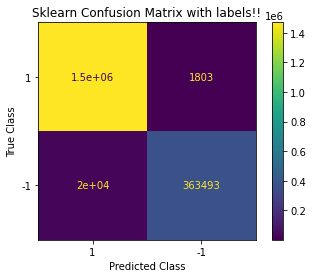

In [43]:
test_performance(y_actual=Y_test.astype('int'),y_predicted=Y_predicted)

**Verifying with new_test**

In [44]:
new_test.drop([' Destination Port','Flow Bytes/s',' Flow Packets/s',' Fwd Header Length.1'],inplace=True,axis=1)
new_test.columns = ['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len',
       'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max',
       'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt',
       'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt',
       'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio',
       'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg',
       'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg',
       'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg',
       'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts',
       'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts',
       'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Mean', 'Active Std',
       'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max',
       'Idle Min', 'Label']
xx = new_test.drop(['Label'],axis=1).drop_duplicates()
xx = pca.transform(ss.transform(xx.values))
p = clf.predict(xx)
np.unique(p,return_counts=True) 


(array([-1,  1]), array([ 2, 66]))